# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
# Ejemplo de optimizacion bayesiana, univariada

# limpio la memoria
rm(list = ls()) # remove all objects
gc() # garbage collection

require("data.table")
# paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width = 20, repr.plot.height = 10)


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,632514,33.8,1413418,75.5,1018937,54.5
Vcells,1171494,9.0,8388608,64.0,1815612,13.9


Loading required package: data.table

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: ‘checkmate’


The following object is masked from ‘package:DiceKriging’:

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [2]:
func_univariada01 <- function(x) {
  y <- -2 * (x + 13) * (x - 3) * (x - 7) * (x - 19)

  return(y)
}


Grafico la funcion

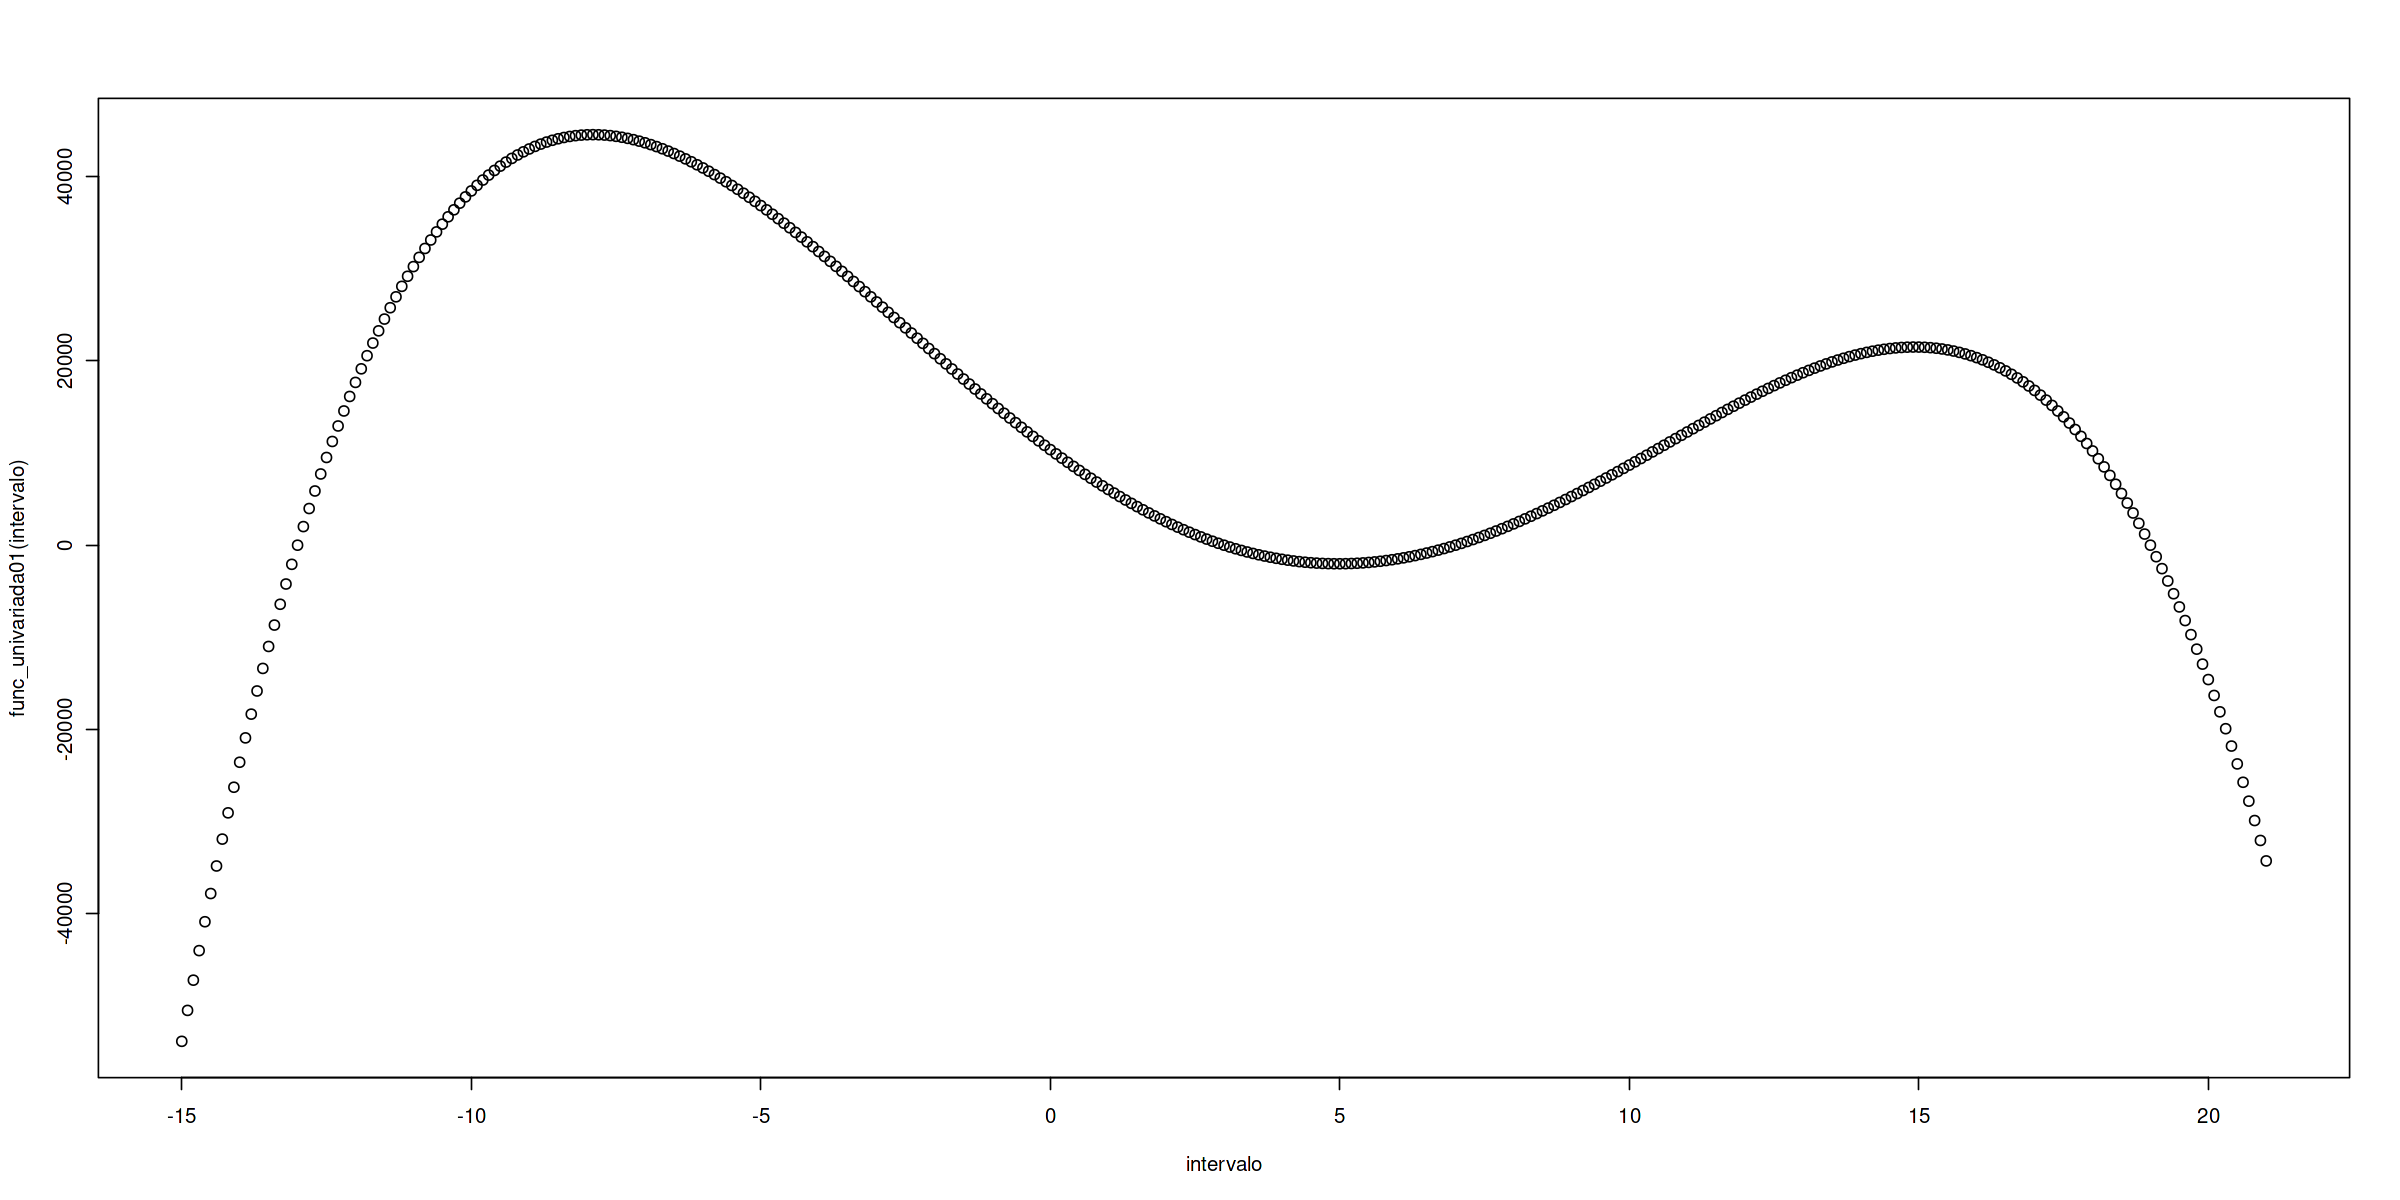

In [3]:
intervalo <- seq(-15, 21, 0.1)
plot(intervalo, func_univariada01(intervalo))


La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [4]:
obj.fun <- makeSingleObjectiveFunction(
    fn = func_univariada01,
    minimize = FALSE, # estoy Maximizando la ganancia
    par.set = makeParamSet(makeNumericParam("x", lower = -100, upper = 100)),
)


ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [5]:
fproxy <- makeLearner(
    cl = "regr.km",
    predict.type = "se",
    covtype = "matern3_2"
)


ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [6]:
ctrl <- makeMBOControl()
ctrl <- setMBOControlInfill(ctrl, crit = makeMBOInfillCritEI())
ctrl <- setMBOControlTermination(ctrl, iters = 25)


finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [7]:
run <- mbo(
    fun = obj.fun,
    learner = fproxy,
    control = ctrl
)


Computing y column(s) for design. Not provided.

[mbo] 0: x=6.4 : y = -992 : 0.0 secs : initdesign

[mbo] 0: x=-32.5 : y = -2.82e+06 : 0.0 secs : initdesign

[mbo] 0: x=90.9 : y = -1.1e+08 : 0.0 secs : initdesign

[mbo] 0: x=-80.1 : y = -9.63e+07 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -76.576 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       76.576  |proj g|=     0.004746
At iterate     1  f =       76.576  |proj g|=      0.004743
At iterate     2  f =        76.56  |proj g|=    0.00082494
At iterate     3  f =        76.56  |proj g|=    8.7142e-05
At iterate     4  f =        76.56  |proj g|=    9.0048e-07
At iterate     5  f =        76.56  |proj g|=    1.1056e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.10557e-09
final function 

[mbo] 1: x=-12.8 : y = 4.32e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -94.47383 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       94.474  |proj g|=    0.0085822
At iterate     1  f =       94.474  |proj g|=     0.0085811
At iterate     2  f =       94.426  |proj g|=     0.0076846
At iterate     3  f =       94.339  |proj g|=     0.0025479
At iterate     4  f =       94.334  |proj g|=    0.00032578
At iterate     5  f =       94.334  |proj g|=    4.7247e-05
At iterate     6  f =       94.334  |proj g|=    7.2659e-07
At iterate     7  f =       94.334  |proj g|=     1.587e-09

iterations 7
function evaluations 11
segments explored during Cauchy searches 7
BFGS updates s

[mbo] 2: x=-2.06 : y = 2.12e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -110.6563 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       110.66  |proj g|=   0.00029301
At iterate     1  f =       110.66  |proj g|=    0.00029292

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000292917
final function value 110.656

F = 110.656
final  value 110.656317 
converged


[mbo] 3: x=-22.7 : y = -6.14e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -126.6712 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       126.67  |proj g|=   0.00067622
At iterate     1  f =       126.67  |proj g|=    0.00067609
At iterate     2  f =       126.67  |proj g|=     4.209e-05
At iterate     3  f =       126.67  |proj g|=    2.8292e-06
At iterate     4  f =       126.67  |proj g|=    1.2915e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.29149e-08
final function value 126.67

F = 126.67
final  value 126.669943 
converge

[mbo] 4: x=21.2 : y = -3.95e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -144.0613 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       144.06  |proj g|=   3.9377e-05
At iterate     1  f =       144.06  |proj g|=    3.9373e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.93727e-05
final function value 144.061

F = 144.061
final  value 144.061340 
converged


[mbo] 5: x=15 : y = 2.15e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -159.3964 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        159.4  |proj g|=   8.6932e-05
At iterate     1  f =        159.4  |proj g|=    8.6925e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 8.69248e-05
final function value 159.396

F = 159.396
final  value 159.396439 
converged


[mbo] 6: x=-7.55 : y = 4.44e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -173.9602 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       173.96  |proj g|=   0.00028922
At iterate     1  f =       173.96  |proj g|=     0.0002892

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000289203
final function value 173.96

F = 173.96
final  value 173.960219 
converged


[mbo] 7: x=18.4 : y = 6.98e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -187.8478 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       187.85  |proj g|=   0.00031922
At iterate     1  f =       187.85  |proj g|=    0.00031921

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000319205
final function value 187.848

F = 187.848
final  value 187.847849 
converged


[mbo] 8: x=10.6 : y = 1.09e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -201.8399 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       201.84  |proj g|=   0.00010409
At iterate     1  f =       201.84  |proj g|=    0.00010409

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00010409
final function value 201.84

F = 201.84
final  value 201.839946 
converged


[mbo] 9: x=2.05 : y = 2.38e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -215.7261 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       215.73  |proj g|=   0.00014745
At iterate     1  f =       215.73  |proj g|=    0.00014744

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000147443
final function value 215.726

F = 215.726
final  value 215.726099 
converged


[mbo] 10: x=-16.7 : y = -1.23e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -229.7716 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       229.77  |proj g|=   2.7296e-05
At iterate     1  f =       229.77  |proj g|=    2.7296e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 2.7296e-05
final function value 229.772

F = 229.772
final  value 229.771604 
converged


[mbo] 11: x=-4.92 : y = 3.65e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -242.9535 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       242.95  |proj g|=   0.00034362
At iterate     1  f =       242.95  |proj g|=    0.00034361

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000343614
final function value 242.953

F = 242.953
final  value 242.953472 
converged


[mbo] 12: x=-10.1 : y = 3.8e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -255.995 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       255.99  |proj g|=    0.0012574
At iterate     1  f =       255.99  |proj g|=     0.0012574
At iterate     2  f =       255.97  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 255.97

F = 255.97
final  value 255.969952 
converged


[mbo] 13: x=27.8 : y = -3.68e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -271.8165 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       271.82  |proj g|=    0.0020472
At iterate     1  f =       271.82  |proj g|=     0.0020472
At iterate     2  f =       271.76  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 271.76

F = 271.76
final  value 271.760187 
converged


[mbo] 14: x=24.4 : y = -1.53e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -285.3754 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       285.38  |proj g|=    0.0025555
At iterate     1  f =       285.38  |proj g|=     0.0025554
At iterate     2  f =       285.31  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 285.306

F = 285.306
final  value 285.306032 
converged


[mbo] 15: x=12.8 : y = 1.83e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -298.0793 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       298.08  |proj g|=     0.002196
At iterate     1  f =       298.08  |proj g|=     0.0021959
At iterate     2  f =       298.07  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 298.065

F = 298.065
final  value 298.065362 
converged


[mbo] 16: x=4.22 : y = -1.73e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -310.8554 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       310.86  |proj g|=     0.003162
At iterate     1  f =       310.86  |proj g|=     0.0031619
At iterate     2  f =        310.8  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 310.803

F = 310.803
final  value 310.803026 
converged


[mbo] 17: x=-0.109 : y = 1.09e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -323.3745 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       323.37  |proj g|=    0.0031832
At iterate     1  f =       323.37  |proj g|=     0.0031831
At iterate     2  f =       323.36  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 323.362

F = 323.362
final  value 323.362138 
converged


[mbo] 18: x=8.56 : y = 3.92e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -335.9205 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       335.92  |proj g|=    0.0036691
At iterate     1  f =       335.92  |proj g|=      0.003669
At iterate     2  f =       335.91  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 335.911

F = 335.911
final  value 335.910686 
converged


[mbo] 19: x=-6.28 : y = 4.19e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -347.9066 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       347.91  |proj g|=    0.0048225
At iterate     1  f =       347.91  |proj g|=     0.0048222
At iterate     2  f =       347.83  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 347.832

F = 347.832
final  value 347.832330 
converged


[mbo] 20: x=16.6 : y = 1.84e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -360.143 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       360.14  |proj g|=    0.0054513
At iterate     1  f =       360.14  |proj g|=      0.005451
At iterate     2  f =       360.05  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 360.054

F = 360.054
final  value 360.053977 
converged


[mbo] 21: x=-8.82 : y = 4.35e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -371.8795 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       371.88  |proj g|=    0.0056103
At iterate     1  f =       371.88  |proj g|=       0.00561
At iterate     2  f =       371.83  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 371.827

F = 371.827
final  value 371.826763 
converged


[mbo] 22: x=-3.55 : y = 2.95e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -383.846 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       383.85  |proj g|=    0.0067894
At iterate     1  f =       383.85  |proj g|=      0.006789
At iterate     2  f =       383.72  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 383.717

F = 383.717
final  value 383.717490 
converged


[mbo] 23: x=-11.3 : y = 2.67e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -395.5548 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       395.55  |proj g|=    0.0061933
At iterate     1  f =       395.55  |proj g|=      0.006193
At iterate     2  f =       395.55  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 395.553

F = 395.553
final  value 395.552600 
converged


[mbo] 24: x=-14.5 : y = -3.79e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -408.3233 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       408.32  |proj g|=     0.010429
At iterate     1  f =       408.32  |proj g|=      0.010428
At iterate     2  f =       407.89  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 407.891

F = 407.891
final  value 407.891130 
converged


[mbo] 25: x=-8.17 : y = 4.45e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  342.0856 
  - best initial criterion value(s) :  -418.9203 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       418.92  |proj g|=    0.0098675
At iterate     1  f =       418.92  |proj g|=     0.0098667
At iterate     2  f =        418.6  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 418.603

F = 418.603
final  value 418.603239 
converged


In [8]:
tb_resultados <- as.data.table(run$opt.path)


In [9]:
tb_resultados


x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
6.4040255,-9.916857e+02,0,NA,NA,0.014,NA,NA,NA,initdesign,NA,NA,NA
-32.5052824,-2.818267e+06,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
90.9349366,-1.103661e+08,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-80.1078387,-9.629649e+07,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-12.7824383,4.317712e+03,1,NA,NA,0.000,-12390475.645,NA,0.088,infill_ei,0.261,27219256.04,2935844.505
-2.0649330,2.115192e+04,2,NA,NA,0.000,-3047087.110,NA,0.036,infill_ei,0.243,6146677.38,1114391.154
-22.6751067,-6.144224e+05,3,NA,NA,0.000,-1967712.804,NA,0.024,infill_ei,0.240,3803486.22,850052.098
21.2271646,-3.953582e+04,4,NA,NA,0.000,-816708.386,NA,0.029,infill_ei,0.301,9281178.56,-8992160.928
14.9973774,2.150433e+04,5,NA,NA,0.000,-1142704.039,NA,0.024,infill_ei,0.260,1783455.54,762400.770


In [10]:
tb_resultados[which.max(tb_resultados$y)]


x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-8.172417,44472.33,25,NA,NA,0,-7234.301,NA,0.031,infill_ei,0.282,18069.75,44471.51


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?